## Intro to Lap-Lap

- Diffusion Eq
- discretisation
![title](images/1.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gt4py
from gt4py import gtscript

In [2]:
@gtscript.stencil(backend="numpy")
def laplacian_stencil(
    in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]
):

    with computation(PARALLEL), interval(...):
        out_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        
@gtscript.stencil(backend="numpy")
def diffusion_update_stencil(
    in_storage: gtscript.Field[float], out_storage: gtscript.Field[float], alpha: float
):

    with computation(PARALLEL), interval(...):
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]

Initial Condition


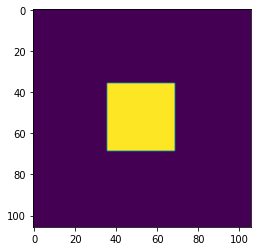

Output


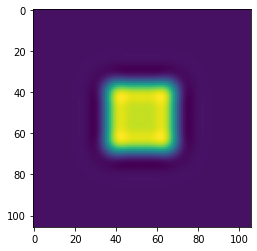

In [3]:
# Setting up the domain
nx = 100
halo = 3
shape = (nx+2*halo, nx+2*halo, 1)

# and the storages
in_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)
in_storage.data[halo + nx // 3 : halo +  2 * nx // 3,halo + nx // 3 : halo + 2 * nx // 3, :] = 1
out_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)
tmp_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)

# running the computataion
print("Initial Condition")
plt.imshow(in_storage.data[:,:,0])
plt.show()

alpha = 1.0 / 32.0
for i in range(500):
    laplacian_stencil(in_storage, tmp_storage, origin=(halo-1, halo-1, 0), domain=(nx+1, nx+1, 1))
    laplacian_stencil(tmp_storage, out_storage, origin=(halo, halo, 0), domain=(nx, nx, 1))
    diffusion_update_stencil(in_storage, out_storage,alpha,   origin=(halo, halo, 0), domain=(nx, nx, 1))
    in_storage.data[:] = out_storage.data[:]

print("Output")
plt.imshow(out_storage.data[:,:,0])
plt.show()

## into to the execution model
- statement after statement, horizontal is fine
- "magic" extension to what is consumed

Initial Condition


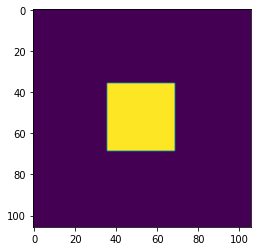

Output


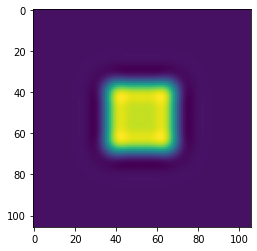

In [4]:
@gtscript.stencil(backend="numpy")
def diffusion_stencil(
    in_storage: gtscript.Field[float],
    out_storage: gtscript.Field[float],
    tmp_storage: gtscript.Field[float],
    alpha: float,
):

    with computation(PARALLEL), interval(...):
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]


nx = 100
halo = 3
shape = (nx + 2 * halo, nx + 2 * halo, 1)
in_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)
in_storage.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
out_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)
tmp_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)

print("Initial Condition")
plt.imshow(in_storage.data[:, :, 0])
plt.show()

alpha = 1.0 / 32.0
for i in range(500):
    diffusion_stencil(
        in_storage, out_storage, tmp_storage, alpha, origin=(halo, halo, 0), domain=(nx, nx, 1)
    )
    in_storage.data[:] = out_storage.data[:]

print("Output")
plt.imshow(out_storage.data[:, :, 0])
plt.show()


## intro to temporary fields
- They can be fields, they can be local variables
- use as see fit

Initial Condition


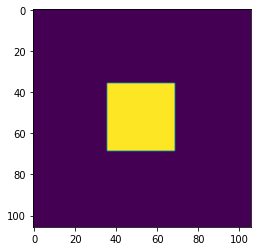

Output


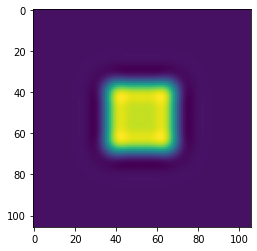

In [5]:
@gtscript.stencil(backend="numpy")
def diffusion_stencil(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        alpha = 1.0 / 32.0
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]
        in_storage = out_storage


nx = 100
halo = 3
shape = (nx + 2 * halo, nx + 2 * halo, 1)
in_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)
in_storage.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
out_storage = gt4py.storage.zeros(
    shape=shape,
    default_origin=(0, 0, 0),
    dtype=float,
    backend="numpy",
)

print("Initial Condition")
plt.imshow(in_storage.data[:, :, 0])
plt.show()

for i in range(500):
    diffusion_stencil(in_storage, out_storage, origin=(halo, halo, 0), domain=(nx, nx, 1))

print("Output")
plt.imshow(out_storage.data[:, :, 0])
plt.show()


## Intro to backends
why

In [6]:
import timeit

iterations = np.arange(1,6)

In [7]:
@gtscript.stencil(backend="numpy")
def diffusion_stencil(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        alpha = 1.0 / 32.0
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]
        in_storage = out_storage


In [8]:
def run_numpy_experiment(size):
    nx = 100*size
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, 1)
    in_storage = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="numpy",
    )
    in_storage.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
    out_storage = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="numpy",
    )

    tic = timeit.default_timer()
    for i in range(500):
        diffusion_stencil(in_storage, out_storage, origin=(halo, halo, 0), domain=(nx, nx, 1))
    toc = timeit.default_timer()
    return toc - tic
    

collect numpy numbers

In [9]:
numpy_values = np.zeros(5)

for j in range(5):
    numpy_values[j] = run_numpy_experiment(iterations[j])



same for gtx86

In [10]:
@gtscript.stencil(backend="gtx86")
def diffusion_stencil_x86(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        alpha = 1.0 / 32.0
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]
        in_storage = out_storage

In [11]:
def run_gtx86_experiment(size):
    gtx86_values = np.zeros(5)
    nx = 100
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, 1)
    in_storage_x86 = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtx86",
    )
    in_storage_x86.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
    out_storage_x86 = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtx86",
    )
    tic = timeit.default_timer()
    for i in range(500):
        diffusion_stencil_x86(in_storage_x86, out_storage_x86, origin=(halo, halo, 0), domain=(nx, nx, 1))
    toc = timeit.default_timer()
    return toc - tic

In [12]:
gtx86_values = np.zeros(5)
for j in range(5):
    gtx86_values[j] = run_gtx86_experiment(iterations[j])

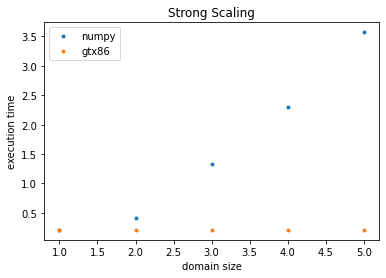

In [13]:
plt.plot(iterations, numpy_values, ".", label="numpy")
plt.plot(iterations, gtx86_values, ".", label="gtx86")


plt.title("Strong Scaling")
plt.legend()
plt.xlabel("domain size")
plt.ylabel("execution time")

plt.show()